In [1]:
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cmo

In [2]:
mpl.rcParams['xtick.labelsize']       = 9
mpl.rcParams['ytick.labelsize']       = 9
mpl.rcParams['lines.linewidth']       = 2.
mpl.rcParams['axes.labelsize']        = 9
#mpl.rcParams['axes.labelweight']      = 'bold'
mpl.rcParams['axes.titlesize']        = 9
mpl.rcParams['font.family']           = 'serif'
#mpl.rcParams['axes.titleweight']      = 'bold'
mpl.rcParams['figure.subplot.bottom'] = .2
mpl.rcParams['figure.subplot.top']    = .95
mpl.rcParams['figure.subplot.left']   = .05
mpl.rcParams['figure.subplot.right']  = .95
mpl.rcParams['figure.subplot.wspace'] = .02
mpl.rcParams['figure.subplot.hspace'] = .0
mpl.rcParams['figure.figsize']        = 7,2


cols = {}
cols['ocean'] = '.7'
cols['land'] = '.9'

In [3]:
def makeglobal(ax):
    ax.set_global()
    ax.add_feature(cfeature.LAND,color=cols['land'])
    ax.add_feature(cfeature.OCEAN,color=cols['ocean'])
    ax.outline_patch.set_visible(False)

In [4]:
#Pure process uncertainties
#Get 1x1 degree grid
with xr.open_dataset('../rawdata/rsl_85_2090.nc') as ds:
#    lon = ds['x'].values
#    lat = ds['y'].values
    slr_md = ds['slr_md'].values

def proc(scen):
    with xr.open_dataset(f'../rawdata/component-ts-slr-{scen[-2:]}.nc') as ds:
        gdyn_h = 100.*np.nanmean(ds['greendyn_h'].values[-20:,:,:],axis=0)
        gdyn_l = 100.*np.nanmean(ds['greendyn_l'].values[-20:,:,:],axis=0)
        lws_h  = 100.*np.nanmean(ds['grw_h'].values[-20:,:,:],axis=0)
        lws_l  = 100.*np.nanmean(ds['grw_l'].values[-20:,:,:],axis=0)
        gia = 100.*np.nanmean(ds['gia_sd'].values[-20:,:,:],axis=0)

    gdyn = (np.abs(gdyn_h-gdyn_l)/(2*1.645))**2.
    lws = (np.abs(lws_h-lws_l)/(2*1.645))**2.
    gia = gia**2.
    gdyn[np.isnan(slr_md)] = np.nan
    lws[np.isnan(slr_md)] = np.nan
    gia[np.isnan(slr_md)] = np.nan
    return gdyn,lws,gia

/Users/erwin/miniconda2/envs/codep/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/Users/erwin/miniconda2/envs/codep/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/Users/erwin/miniconda2/envs/codep/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':
/Users/erwin/miniconda2/envs/codep/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]
/Users/erwin/miniconda2/envs/codep/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  
/Users/erwin/miniconda2/envs/codep/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: Degrees of freedom <= 0 for slice.
/Users/erwin/miniconda2/envs/codep/lib/python3.6/site-packages/ipykernel_launc

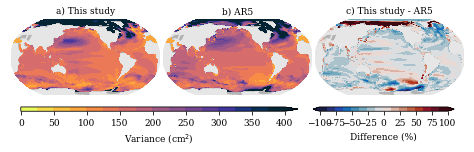

/Users/erwin/miniconda2/envs/codep/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/Users/erwin/miniconda2/envs/codep/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/Users/erwin/miniconda2/envs/codep/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':
/Users/erwin/miniconda2/envs/codep/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]
/Users/erwin/miniconda2/envs/codep/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  
/Users/erwin/miniconda2/envs/codep/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: Degrees of freedom <= 0 for slice.
/Users/erwin/miniconda2/envs/codep/lib/python3.6/site-packages/ipykernel_launc

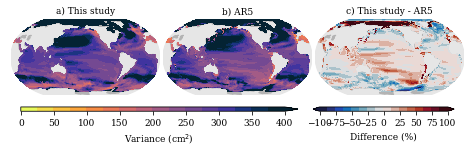

In [5]:
vmax = 400
vmax2 = 100
cmap = plt.get_cmap('cmo.thermal_r',16)
cmap2 = plt.get_cmap('cmo.balance',16)

for s,scen in enumerate(['rcp45','rcp85']):
    with xr.open_dataset(f'../data/ensemble_reg_{scen}.nc') as ds:
        lon = ds['lon'].values
        lat = ds['lat'].values
        stdn = ds['stdn'].values
        glac = ds['glac'].values
        gsmb = ds['gsmb'].values
        asmb = ds['asmb'].values
        adyn = ds['adyn'].values

    gdyn,lws,gia = proc(scen) 
    
    rsl = np.nanvar(stdn+glac+gsmb+asmb+adyn,axis=(0,1))
    rsl+= np.nanvar(glac,axis=(0,1))+gdyn+lws+gia

    with xr.open_dataset(f'../rawdata/ar5/totslr-{scen}-4.nc') as ds:
        ar5 = (100.*ds['totslr_sd'].values)**2

    fig = plt.figure()
    
    ax = fig.add_subplot(1,3,1,projection=ccrs.Robinson(central_longitude=200))
    im = ax.pcolormesh(lon,lat,rsl,transform=ccrs.PlateCarree(),vmin=0,vmax=vmax,cmap=cmap)
    ax.set_title('a) This study')
    makeglobal(ax)
    
    ax = fig.add_subplot(1,3,2,projection=ccrs.Robinson(central_longitude=200))
    im = ax.pcolormesh(lon,lat,ar5,transform=ccrs.PlateCarree(),vmin=0,vmax=vmax,cmap=cmap)
    ax.set_title('b) AR5')
    makeglobal(ax)

    cax = fig.add_axes([.07,.2,.55,.03])
    cb = plt.colorbar(im,cax=cax,orientation='horizontal',extend='max')
    cb.set_label('Variance (cm$^2$)')
    
    ax = fig.add_subplot(1,3,3,projection=ccrs.Robinson(central_longitude=200))
    im = ax.pcolormesh(lon,lat,100.*(rsl-ar5)/ar5,transform=ccrs.PlateCarree(),vmin=-vmax2,vmax=vmax2,cmap=cmap2)
    ax.set_title('c) This study - AR5')
    makeglobal(ax)
    
    cax = fig.add_axes([.65,.2,.28,.03])
    cb = plt.colorbar(im,cax=cax,orientation='horizontal',extend='both')
    cb.set_label('Difference (%)')
    
    figname = f'draftplot_totvar_{scen}.png'

    plt.savefig(f'../figures/{figname}',dpi=600)
    plt.savefig(f'../../../writing/codependence/figures/{figname}',dpi=600)
    plt.show()
    plt.close()    